## Final Project Submission

Please fill out:
* Student name: Eduardo Calzadilla
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Movie genre and title recommendations

#### Datasets: 
    1. IMDB
    2. Rotten Tomatoes
    3. TheMovieDB.org
    4. Box Office Mojo





## Contents

**A. [Exploratory Data Analysis](#EDA)** <br>
  1. [Initial exploration and cleanup](#Iec)<br>
  2. [Joins](#Tj)<br>
  
**B. [ROI, ratings and production budget](#Rrpb)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; What is the relationship between ROI, production budget and rating?<br>
**C. [Genres, ROI and rating](#Grr)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Are there genres that have ratings within our specified range? If so what are their associated ROIs?<br>
**D. [Runtime and production budget](#Rpb)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; What is the best range for runtime relative to production budget?<br>
**E. [Expected competition](#Ec)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is there a change in the number of released movies from 2015-2019 compared to five years prior?<br>


 

## Introduction & Summary

Throughout this notebook we will be exploring three datasets as highlighted above, in order to spot trend that could be indicative of higher succes capacity and return on investment (ROI). 

We will be focusing on the following four null hypotheses:
  1. Movies with higher ratings do not perform significantly better in terms of gross income and ROI.
  2. All genres perform equally in terms of ratings, gross income and ROI.
  3. There are no words that are indicative of higher performance in terms of ratings and ROI. -- change to runtime 
  4. There has been no change in terms of competition (number of movies coming out) 4 year prior to 2015 and 4 year after 2015. 

We have found that there are significant similarities between median ratings and median performance. etc...

In [2]:
# Importing necessary packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import zipfile
%matplotlib inline

In [3]:
# Passing zip doc filenames to a list for storing DataFrames. 
zippedData = glob.glob("zippedData/*.gz")

In [4]:
# Verifyig that all the docs in zippedData were read correctly
zippedData

['zippedData/imdb.title.crew.csv.gz',
 'zippedData/tmdb.movies.csv.gz',
 'zippedData/imdb.title.akas.csv.gz',
 'zippedData/imdb.title.ratings.csv.gz',
 'zippedData/imdb.name.basics.csv.gz',
 'zippedData/rt.reviews.tsv.gz',
 'zippedData/imdb.title.basics.csv.gz',
 'zippedData/rt.movie_info.tsv.gz',
 'zippedData/tn.movie_budgets.csv.gz',
 'zippedData/bom.movie_gross.csv.gz',
 'zippedData/imdb.title.principals.csv.gz']

In [5]:
# Ceate list of variables for storing DataFrames.
df_name=[]
for filename in zippedData:
    df_name.append("df_" + filename.split("/",1)[1].split(".",3)[0] 
                + "_" + filename.split("/",1)[1].split(".",3)[1] 
                + "_" + filename.split("/",1)[1].split(".",3)[2])

In [6]:
df_dic={}
i = 0
for filename in zippedData:
    if "csv" in filename:
        df_dic[df_name[i]] = pd.read_csv(filename,
                             compression='gzip')
    else: 
        df_dic[df_name[i]] = pd.read_csv(filename
                                   , sep='\t'
                                   , encoding = 'unicode_escape')
    i+=1
    

In [7]:
df_imdb_title_crew = df_dic["df_imdb_title_crew"]
df_imdb_title_akas = df_dic["df_imdb_title_akas"]
df_imdb_title_ratings = df_dic["df_imdb_title_ratings"]
df_imdb_name_basics = df_dic["df_imdb_name_basics"]
df_imdb_title_basics = df_dic["df_imdb_title_basics"]
df_imdb_title_principals = df_dic["df_imdb_title_principals"]

df_rt_movie_info_tsv = df_dic["df_rt_movie_info_tsv"]
df_rt_reviews_tsv = df_dic["df_rt_reviews_tsv"]

df_tmdb_movies_csv = df_dic["df_tmdb_movies_csv"]

df_tn_movie_budgets_csv = df_dic["df_tn_movie_budgets_csv"]

df_bom_movie_gross_csv = df_dic["df_bom_movie_gross_csv"]


<a id="EDA"></a>

## EXPLORATORY DATA ANALYSIS

Now that the datastes are loaded into DataFrames, we will explore the datasets to understand the data present in each. Later we will drill into the data to understand possible null values and start cleaning the same for joining and use. 

As we see the data for the first time, we will make note of potential areas for cleanup.

In [8]:
df_imdb_title_crew.head(2)

tconst  directors              writers
0  tt0285252  nm0899854            nm0899854
1  tt0438973        NaN  nm0175726,nm1802864

As we see above the all columns seem to contain secondary keys, or it could also contain useless data. We will verify as we see other IMBD datasets, and considering possible joins.

In [9]:
df_imdb_title_akas.head(2)

title_id  ordering              title region language        types  \
0  tt0369610        10      Джурасик свят     BG       bg          NaN   
1  tt0369610        11  Jurashikku warudo     JP      NaN  imdbDisplay   

  attributes  is_original_title  
0        NaN                0.0  
1        NaN                0.0

Above we see that this df contains movie titles, and lists (in binary) if the title is the original, as well as the region and language it was released in. We will find more about attribute values later on. For now we are assuming original titles are pre-release or location specific. 

We can also see that the "title id" column has a similar format to the "tconst" column in the previous df.

In [10]:
df_imdb_title_ratings.head(2)

tconst  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559

It now seems that the "tconst" column in the first df joins with this df rather than the "df_imdb_title_akas" df. And this df provides the ratings as well as number of votes for each score. 

In [11]:
df_imdb_name_basics.head(2)

nconst       primary_name  birth_year  death_year  \
0  nm0061671  Mary Ellen Bauder         NaN         NaN   
1  nm0061865       Joseph Bauer         NaN         NaN   

                           primary_profession  \
0   miscellaneous,production_manager,producer   
1  composer,music_department,sound_department   

                          known_for_titles  
0  tt0837562,tt2398241,tt0844471,tt0118553  
1  tt0896534,tt6791238,tt0287072,tt1682940

In this df we see data associated with crew members and their associated movies. Given the nature of our study, we will probably ignore this table altogether, unless it proves necessary for joining tables. 

In [12]:
df_imdb_title_basics.head(2)

tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0            175.0  Action,Crime,Drama  
1            114.0     Biography,Drama

Here we see the genre data and that it can be joined to the "df_imdb_title_ratings" df. 

In [13]:
df_imdb_title_principals.head(2)

tconst  ordering     nconst  category  job   characters
0  tt0111414         1  nm0246005     actor  NaN  ["The Man"]
1  tt0111414         2  nm0398271  director  NaN          NaN

This df contains a joining column for all other columns, except the "df_imdb_title_akas" df. It provides parsed information on the roles of the cast and crew related dataframe. 

In [14]:
df_rt_reviews_tsv.head(2)

id                                             review rating   fresh  \
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh   
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   

           critic  top_critic        publisher               date  
0      PJ Nabarro           0  Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0          io9.com       May 23, 2018

It seems the above dataframe contains review information, and names and publishing means of the critic (also read "movie-viewer") who posted the same. It could be joined to specific movie using the id column. 

We will verify if this is the case with the following df. 

In [15]:
df_rt_movie_info_tsv.head(2)

id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   

                         writer  theater_date      dvd_date currency  \
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One

Our original assumption seems correct in that the RottenTomatoes DataFrames can be joined using the "id" column in the previous table. However, we do not have the name of the film which might be useful for our word count analysis - however, it might not be necessary if we already have enough data samples from IMDB, for example.  

Additionally this dataframe contains "writer", "director", "dvd_date", and "studio" columns which will not be useful for our analysis, but the "director" and "writer" columns could be used for joining to movie titles. We will also need to further investigate the "rating" columns as it seems that the column in this table is specifying the Motion Picture Association (MPA) rating system, rather than point ratings associated with a review.

In [16]:
df_tmdb_movies_csv.head(2)

Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610

In the above we see that the "Unnamed:0" column can probably be deleted as it seems to contain an index rather than the primary key, as there is another column named "id". 

We can also probably delete one of the title columns. We will be keeping the "title" column, rather than the "original title" column, as we are making the assumption that the latter contains titles used while working on the movie (or prerelease titles).

In [17]:
df_tn_movie_budgets_csv.head(2)

id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875

In [18]:
df_bom_movie_gross_csv.head(2)

title studio  domestic_gross foreign_gross  year
0                 Toy Story 3     BV     415000000.0     652000000  2010
1  Alice in Wonderland (2010)     BV     334200000.0     691300000  2010

In the above we can see both dataframes contain financial data.

We don't need both dataframes and will choose the former as it contains the full release date and the production budget. Both will be useful for our analysis, and the exact release date can allow us more granularity on when to release Microsoft's first film.  

<a id="Iec"></a>
## Initial exploration and cleanup

Let's take a quick recap on what we've learned from each dataset so far.

1. df_imdb_title_crew: is a joining table, it joins between df_imdb_title_ratings and df_imdb_title_basics, which we can use to title ratings, gender, gross income and ROI (useful for testing our first and second hypotheses) by joining on movie titles with the df_tn_movie_budgets_csv <br><br>

2. df_tn_movie_budgets_csv: contains financial information as well as the name of the movies, which we will use to join on IMDB tables. <br><br>

3. df_tmdb_movies_csv: can also be joined to df_tn_movie_budgets_csv using the title field, which can inform our first and third hypotheses. <br><br>

4. df_rt_movie_info_tsv: can join with df_rt_reviews_tsv using the id columns, and we can then compare ratings, genre and release date, as well as gross domestic income for hypotheses 1,2 and 4.  <br><br>

Now we will start examining and cleaning the data. Let's make note that for our analytical purposes df_imdb_title_principals and df_imdb_name_basics won't be useful, so we will br ignoring these tables altogether.

During the cleanup process we will be looking at potential missing data that could be expressed as other than null. Unique values that could be indicative of missing data, include the following:
- Impossible values
- Null categories
- 0's where not logical


In [19]:
df_imdb_title_ratings.info() 
# Since there are no noticeable nulls, and we can 
# safely assume all columns are foreign keys given our 
# initial lookthrough, we will continue with the next df. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [20]:
df_imdb_title_ratings.describe(include=np.object)
# Given our initial lookthrough, and that 
# the "tconst" column contains all unique values
# we can safely assume they are primery and a foreign key.

tconst
count       73856
unique      73856
top     tt5281646
freq            1

In [21]:
df_imdb_title_ratings.describe() 
# Here we can note that the averages for ratings
# don't vary significantly. 

averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06

In [22]:
for column in df_imdb_title_ratings.columns:
    print(df_imdb_title_ratings[column].value_counts())
# None of the following seems to be possible 
# null values so let's move on.

tt5281646    1
tt4602342    1
tt3810760    1
tt5004776    1
tt4067578    1
            ..
tt0831280    1
tt3720802    1
tt5652594    1
tt7564298    1
tt5477450    1
Name: tconst, Length: 73856, dtype: int64
7.0     2262
6.6     2251
7.2     2249
6.8     2239
6.5     2221
        ... 
9.6       18
10.0      16
9.8       15
9.7       12
9.9        5
Name: averagerating, Length: 91, dtype: int64
6        2875
5        2699
7        2476
8        2167
9        1929
         ... 
18286       1
16289       1
1958        1
4007        1
4098        1
Name: numvotes, Length: 7349, dtype: int64


In [23]:
for column in df_imdb_title_basics.columns:
    print(df_imdb_title_basics[column].value_counts())
    
print(df_imdb_title_basics.info())
df_imdb_title_basics.describe() 

# Again we see no indication of othery types of null values
# and we see little effect on the "genre" and "runtime_min"
# columns

tt5238664    1
tt4838440    1
tt6695888    1
tt2330366    1
tt3722174    1
            ..
tt6254720    1
tt6787962    1
tt2231034    1
tt2312300    1
tt5477450    1
Name: tconst, Length: 146144, dtype: int64
Home                                                                     24
The Return                                                               20
Broken                                                                   20
Homecoming                                                               16
Alone                                                                    16
                                                                         ..
Beauty of the Mind                                                        1
Kutty Pisasu                                                              1
Ensemble, nous allons vivre une très, très grande histoire d'amour...     1
Dying To Clothe You                                                       1
In the Stream                   

start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

In [24]:
# Let's continue by removing columns we won't 
# need for our analysis
df_imdb_title_genre = df_imdb_title_basics.copy()

# Also, since we will need genre, let's remove 
# columns with nulls in the genre column 
# since these would constitute only  the 3% of the data.
df_imdb_title_genre.dropna(subset=["genres"],inplace=True)

print(df_imdb_title_genre.info())
df_imdb_title_genre.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140736 entries, 0 to 146143
Data columns (total 6 columns):
tconst             140736 non-null object
primary_title      140736 non-null object
original_title     140734 non-null object
start_year         140736 non-null int64
runtime_minutes    112233 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 7.5+ MB
None


tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0            175.0  Action,Crime,Drama  
1            114.0     Biography,Drama

In [25]:
# Converting genre column into a list --- MIGHT HAVE TO JOIN BEFORE EXPANSION
df_imdb_title_genre["genres"] = df_imdb_title_genre["genres"].str.split(",")
df_imdb_title_genre_expanded = df_imdb_title_genre.copy()

# Expand list into rows
rows = []
_ = df_imdb_title_genre_expanded.apply(lambda row: [rows.append([row['tconst'], row['primary_title']
                                                        , row["original_title"], row["start_year"] 
                                                        , row["runtime_minutes"], nn]) 
                         for nn in row.genres], axis=1)
df_imdb_title_genre_expanded = pd.DataFrame(rows, columns=df_imdb_title_genre_expanded.columns)


In [26]:
df_imdb_title_genre.head(2)

tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes                  genres  
0            175.0  [Action, Crime, Drama]  
1            114.0      [Biography, Drama]

In [27]:
df_imdb_title_genre_expanded.head(2)

tconst primary_title original_title  start_year  runtime_minutes  genres
0  tt0063540     Sunghursh      Sunghursh        2013            175.0  Action
1  tt0063540     Sunghursh      Sunghursh        2013            175.0   Crime

In [28]:
for column in df_tn_movie_budgets_csv.columns:
    print(df_tn_movie_budgets_csv[column].value_counts())
    
df_tn_movie_budgets_csv.info()

# Again no noticeable null placeholder values and no nulls

4      58
53     58
61     58
65     58
69     58
       ..
85     57
100    57
96     57
92     57
97     57
Name: id, Length: 100, dtype: int64
Dec 31, 2014    24
Dec 31, 2015    23
Dec 31, 2010    15
Dec 31, 2008    14
Dec 31, 2012    13
                ..
Sep 15, 1999     1
Nov 27, 1991     1
Feb 3, 2010      1
Jun 25, 1999     1
Feb 14, 1991     1
Name: release_date, Length: 2418, dtype: int64
Home                     3
Halloween                3
King Kong                3
The Island               2
Friday the 13th          2
                        ..
We Own the Night         1
The Prisoner of Zenda    1
Elektra                  1
Goodbye Bafana           1
What Lies Beneath        1
Name: movie, Length: 5698, dtype: int64
$20,000,000    231
$10,000,000    212
$30,000,000    177
$15,000,000    173
$25,000,000    171
              ... 
$77,000,000      1
$23,600,000      1
$323,000         1
$7,800,000       1
$775,000         1
Name: production_budget, Length: 509, dtype: int64
$

In [29]:
# Dropping id column which won't be useful for us
df_tn_movie_budgets = df_tn_movie_budgets_csv.drop("id", axis=1)

# Expanding release_date column
df_tn_movie_budgets['release_date'] = pd.to_datetime(df_tn_movie_budgets['release_date'])

df_tn_movie_budgets['day'] = df_tn_movie_budgets['release_date'].dt.day
df_tn_movie_budgets['month'] = df_tn_movie_budgets['release_date'].dt.month
df_tn_movie_budgets['year'] = df_tn_movie_budgets['release_date'].dt.year

df_tn_movie_budgets.head(2)

release_date                                        movie production_budget  \
0   2009-12-18                                       Avatar      $425,000,000   
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides      $410,600,000   

  domestic_gross worldwide_gross  day  month  year  
0   $760,507,625  $2,776,345,279   18     12  2009  
1   $241,063,875  $1,045,663,875   20      5  2011

In [30]:
# Convert amounts in string currency to float
currency_columns = ["production_budget", "domestic_gross", "worldwide_gross"]

for column in currency_columns:
    df_tn_movie_budgets[[column]] = df_tn_movie_budgets[[column]].replace('[\$,]','',regex=True).astype(float)


In [31]:
# Double check changes
df_tn_movie_budgets.info()
df_tn_movie_budgets.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
release_date         5782 non-null datetime64[ns]
movie                5782 non-null object
production_budget    5782 non-null float64
domestic_gross       5782 non-null float64
worldwide_gross      5782 non-null float64
day                  5782 non-null int64
month                5782 non-null int64
year                 5782 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 361.5+ KB


release_date                                        movie  \
0   2009-12-18                                       Avatar   
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   

   production_budget  domestic_gross  worldwide_gross  day  month  year  
0        425000000.0     760507625.0     2.776345e+09   18     12  2009  
1        410600000.0     241063875.0     1.045664e+09   20      5  2011

In [32]:
df_tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
release_date         5782 non-null datetime64[ns]
movie                5782 non-null object
production_budget    5782 non-null float64
domestic_gross       5782 non-null float64
worldwide_gross      5782 non-null float64
day                  5782 non-null int64
month                5782 non-null int64
year                 5782 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 361.5+ KB


In [33]:
for column in df_tmdb_movies_csv.columns:
    print(df_tmdb_movies_csv[column].value_counts())
    
df_tmdb_movies_csv.info()


2047     1
5448     1
3371     1
13612    1
15661    1
        ..
12979    1
2740     1
693      1
6838     1
0        1
Name: Unnamed: 0, Length: 26517, dtype: int64
[99]                        3700
[]                          2479
[18]                        2268
[35]                        1660
[27]                        1145
                            ... 
[28, 12, 16, 878, 10752]       1
[28, 14, 27, 18]               1
[16, 12, 18, 10751, 878]       1
[16, 28, 35, 9648]             1
[53, 35, 27, 18, 9648]         1
Name: genre_ids, Length: 2477, dtype: int64
292086    3
463839    3
11976     3
391872    3
416572    3
         ..
356987    1
350846    1
479871    1
500353    1
524288    1
Name: id, Length: 25497, dtype: int64
en    23291
fr      507
es      455
ru      298
ja      265
      ...  
ps        1
sw        1
bo        1
nb        1
si        1
Name: original_language, Length: 76, dtype: int64
Eden                               7
Home                               6


In [34]:
# First let's drop the columns we won't need, 
# and let's keep titles in english for ease of comparison
df_tmdb_movies = df_tmdb_movies_csv.drop(["Unnamed: 0","genre_ids","popularity"], axis=1)

df_tmdb_movies = df_tmdb_movies.loc[df_tmdb_movies.original_language =='en']

# Then let's expand on the release date into three columns, one for day, month and year 
# for ease of visualization
df_tmdb_movies['release_date'] = pd.to_datetime(df_tmdb_movies['release_date'])

df_tmdb_movies['day'] = df_tmdb_movies['release_date'].dt.day
df_tmdb_movies['month'] = df_tmdb_movies['release_date'].dt.month
df_tmdb_movies['year'] = df_tmdb_movies['release_date'].dt.year


df_tmdb_movies.info()

df_tmdb_movies.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23291 entries, 0 to 26516
Data columns (total 10 columns):
id                   23291 non-null int64
original_language    23291 non-null object
original_title       23291 non-null object
release_date         23291 non-null datetime64[ns]
title                23291 non-null object
vote_average         23291 non-null float64
vote_count           23291 non-null int64
day                  23291 non-null int64
month                23291 non-null int64
year                 23291 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 2.0+ MB


id original_language                                original_title  \
0  12444                en  Harry Potter and the Deathly Hallows: Part 1   
1  10191                en                      How to Train Your Dragon   

  release_date                                         title  vote_average  \
0   2010-11-19  Harry Potter and the Deathly Hallows: Part 1           7.7   
1   2010-03-26                      How to Train Your Dragon           7.7   

   vote_count  day  month  year  
0       10788   19     11  2010  
1        7610   26      3  2010

In [35]:
for column in df_rt_movie_info_tsv.columns:
    print(df_rt_movie_info_tsv[column].value_counts())
    
df_rt_movie_info_tsv.info()


2000    1
697     1
673     1
674     1
675     1
       ..
1347    1
1349    1
1350    1
1351    1
1       1
Name: id, Length: 1560, dtype: int64
A group of air crash survivors are stranded in the Mongolian desert with no chance of rescue. Facing a brutal environment, dwindling resources, and an attack by desert smugglers, they realize their only hope is doing the "impossible"--building a new plane from the wreckage.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Steven Spielberg    10
Clint Eastwood       8
Woody Allen          4
Jim Jarmusch         4
Yimou Zhang          4
                    ..
Peter Landesman      1
Nicholas Stoller     1
Brian Hecker         1
Rose Troche          1
Peque Gallaga        1
Name: director, Length: 1125, dtype: int64
Woody Allen                       4
John Hughes                       3
Jim Jarmusch                      3
Sylvester Stallone                3
Hong Sang-soo                     3
                                 ..
Harold Pinter                     1
Sergio Sollima|Sergio Donati      1
Jean-Luc Godard                   1
Pauly Shore|Kirk Fox              1
Jonathan Bernstein|James Greer    1
Name: writer, Length: 1069, dtype: int64
Jan 1, 1987     8
Jan 1, 1994     5
Jan 1, 1973     4
Jun 1, 1994     4
Jun 1, 1990     4
               ..
Apr 16, 2010    1
May 30, 2003    1
Jan 12, 2018    1
Mar 19, 1993    1
Nov 7, 2008     1
Name: theater_date, Length: 1025, dtype: int64
Jun 1, 2004     11
Nov

In [36]:
# Here we can drop synopsis, rating, dvd_date among others
df_rt_movie_info = df_rt_movie_info_tsv.drop(["synopsis","rating","director","writer","dvd_date","currency","studio"], axis=1)

# Again let's expand on the theatre date into three columns, one for day, month and year 
# for ease of visualization

df_rt_movie_info["theater_date"] = pd.to_datetime(df_rt_movie_info["theater_date"])

df_rt_movie_info['day'] = df_rt_movie_info['theater_date'].dt.day
df_rt_movie_info['month'] = df_rt_movie_info['theater_date'].dt.month
df_rt_movie_info['year'] = df_rt_movie_info['theater_date'].dt.year

# Since the nulls in the genre column constitute less then 1% of the total data
# we will drop these rows. It is also important to note that genre is a list, and we 
# will have to parse these out later.
df_rt_movie_info.dropna(subset=["genre"],inplace=True)

# Unfortunately, we cannot drop the nulls in the theatre_date and box_office columns, 
# we will instead keep them as is and make note of these. 

# Converting box_office to float
df_rt_movie_info["box_office"] = df_rt_movie_info["box_office"].str.replace(',', '').astype(float)


df_rt_movie_info.info()

df_rt_movie_info.head(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552 entries, 0 to 1559
Data columns (total 8 columns):
id              1552 non-null int64
genre           1552 non-null object
theater_date    1201 non-null datetime64[ns]
box_office      340 non-null float64
runtime         1526 non-null object
day             1201 non-null float64
month           1201 non-null float64
year            1201 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 109.1+ KB


id                                genre theater_date  box_office  \
0   1  Action and Adventure|Classics|Drama   1971-10-09         NaN   
1   3    Drama|Science Fiction and Fantasy   2012-08-17    600000.0   

       runtime   day  month    year  
0  104 minutes   9.0   10.0  1971.0  
1  108 minutes  17.0    8.0  2012.0

In [37]:
# Converting genre column into a list 
df_rt_movie_info["genre"] = df_rt_movie_info["genre"].str.split("|")
df_rt_movie_info_expanded = df_rt_movie_info.copy()


# Expand list into rows
rows = []
_ = df_rt_movie_info_expanded.apply(lambda row: [rows.append([row['id'], nn
                                                        , row["theater_date"], row["box_office"] 
                                                        , row["runtime"], row["day"], row["month"], row["year"]]) 
                         for nn in row.genre], axis=1)
df_rt_movie_info_expanded = pd.DataFrame(rows, columns=df_rt_movie_info_expanded.columns)


In [38]:
df_rt_movie_info.head(2)

id                                    genre theater_date  box_office  \
0   1  [Action and Adventure, Classics, Drama]   1971-10-09         NaN   
1   3     [Drama, Science Fiction and Fantasy]   2012-08-17    600000.0   

       runtime   day  month    year  
0  104 minutes   9.0   10.0  1971.0  
1  108 minutes  17.0    8.0  2012.0

In [39]:
df_rt_movie_info_expanded.head(2)

id                 genre theater_date  box_office      runtime  day  month  \
0   1  Action and Adventure   1971-10-09         NaN  104 minutes  9.0   10.0   
1   1              Classics   1971-10-09         NaN  104 minutes  9.0   10.0   

     year  
0  1971.0  
1  1971.0

In [40]:
for column in df_rt_reviews_tsv.columns:
    print(df_rt_reviews_tsv[column].value_counts())
    
df_rt_reviews_tsv.info()

782     338
1067    275
1525    262
1777    260
1083    260
       ... 
28        1
102       1
348       1
476       1
1727      1
Name: id, Length: 1135, dtype: int64
Parental Content Review                                                                                                                                        24
full review at Movies for the Masses                                                                                                                           15
full review in Greek                                                                                                                                            9
Click to read review                                                                                                                                            3
click to read the full review                                                                                                                                   3
                     

In [41]:
# Keeping only relevant columns
df_rt_reviews = df_rt_reviews_tsv[["id","rating","top_critic"]].copy()

# Dropping nans from rating, since it is our main interest, regardless that
# these rows constitute ~25% of the data in the df. 
df_rt_reviews.dropna(subset=["rating"], inplace=True)

# df_rt_reviews["rating"] = df_rt_reviews["rating"].astype(float)



# Standardizing rating scores
# df_rt_reviews["rating"] = pd.eval(df_rt_reviews["rating"].fillna(1000))


In [42]:
to_del = []
to_del_dedup = []
i = 0

# Try to change fraction into decimal if not, set as item to drop from column
for row in df_rt_reviews["rating"]:
    try:
        eval(row)
    except Exception:
        to_del.append(row)
#     else:
#         df_rt_reviews["rating"].iloc[i] = (eval(row))
#         i+=1
        
# Dedup list of items to del from column
for value in to_del:
    if value not in to_del_dedup:
        to_del_dedup.append(value)


In [43]:
df_rt_reviews = df_rt_reviews[~df_rt_reviews['rating'].isin(to_del_dedup)]

In [44]:
i = 0

for row in df_rt_reviews["rating"]:
    df_rt_reviews["rating"].iloc[i] = (eval(row))
    i+=1

/Users/eduardo_calzadilla/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
df_rt_reviews["rating"] = df_rt_reviews["rating"].astype(float) # Verify altered column

In [46]:
df_rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34446 entries, 0 to 54431
Data columns (total 3 columns):
id            34446 non-null int64
rating        34446 non-null float64
top_critic    34446 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.1 MB


While we are left with ~63% of the original dataset length, it is safer not to translate the letter grading into an approximately equivalent numerical grading. 

<a id="Tj"></a>
## Joins

In [47]:
df_imdb_title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [48]:
df_imdb_title_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140736 entries, 0 to 146143
Data columns (total 6 columns):
tconst             140736 non-null object
primary_title      140736 non-null object
original_title     140734 non-null object
start_year         140736 non-null int64
runtime_minutes    112233 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 7.5+ MB


In [49]:
# rceating an expanded set for the genre analysis, but keeping a regular set for ROI analysis
df_imbd_title_and_ratings = df_imdb_title_ratings.join(df_imdb_title_genre.set_index('tconst'), on='tconst')

df_imbd_title_and_ratings_expanded = df_imdb_title_ratings.join(df_imdb_title_genre_expanded.set_index('tconst'), on='tconst')


In [50]:
df_imbd_title_and_ratings.head(2)

tconst  averagerating  numvotes     primary_title    original_title  \
0  tt10356526            8.3        31  Laiye Je Yaarian  Laiye Je Yaarian   
1  tt10384606            8.9       559        Borderless        Borderless   

   start_year  runtime_minutes         genres  
0      2019.0            117.0      [Romance]  
1      2019.0             87.0  [Documentary]

In [51]:
df_imbd_title_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
tconst             73856 non-null object
averagerating      73856 non-null float64
numvotes           73856 non-null int64
primary_title      73052 non-null object
original_title     73052 non-null object
start_year         73052 non-null float64
runtime_minutes    65720 non-null float64
genres             73052 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 4.5+ MB


In [52]:
df_imbd_title_and_ratings_expanded.head(2)

tconst  averagerating  numvotes     primary_title    original_title  \
0  tt10356526            8.3        31  Laiye Je Yaarian  Laiye Je Yaarian   
1  tt10384606            8.9       559        Borderless        Borderless   

   start_year  runtime_minutes       genres  
0      2019.0            117.0      Romance  
1      2019.0             87.0  Documentary

In [53]:
# Here we can see the effect of fanout, which is why this df will only be used for
# observing genre relationships
df_imbd_title_and_ratings_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129294 entries, 0 to 73855
Data columns (total 8 columns):
tconst             129294 non-null object
averagerating      129294 non-null float64
numvotes           129294 non-null int64
primary_title      128490 non-null object
original_title     128490 non-null object
start_year         128490 non-null float64
runtime_minutes    118437 non-null float64
genres             128490 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


In [54]:
df_tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
release_date         5782 non-null datetime64[ns]
movie                5782 non-null object
production_budget    5782 non-null float64
domestic_gross       5782 non-null float64
worldwide_gross      5782 non-null float64
day                  5782 non-null int64
month                5782 non-null int64
year                 5782 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 361.5+ KB


In [55]:
# Joining financial and rating
df_imbd_fin = df_tn_movie_budgets.join(df_imbd_title_and_ratings.set_index('original_title'), on='movie', how='inner')

# Joining financial and rating, genre data 
df_imbd_fin_expanded = df_tn_movie_budgets.join(df_imbd_title_and_ratings_expanded.set_index('original_title'), on='movie', how='inner')


In [56]:
df_imbd_fin.info()
df_imbd_fin.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2633 entries, 1 to 5780
Data columns (total 15 columns):
release_date         2633 non-null datetime64[ns]
movie                2633 non-null object
production_budget    2633 non-null float64
domestic_gross       2633 non-null float64
worldwide_gross      2633 non-null float64
day                  2633 non-null int64
month                2633 non-null int64
year                 2633 non-null int64
tconst               2633 non-null object
averagerating        2633 non-null float64
numvotes             2633 non-null int64
primary_title        2633 non-null object
start_year           2633 non-null float64
runtime_minutes      2530 non-null float64
genres               2633 non-null object
dtypes: datetime64[ns](1), float64(6), int64(4), object(4)
memory usage: 329.1+ KB


release_date                                        movie  \
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   2019-06-07                                 Dark Phoenix   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   
2        350000000.0      42762350.0     1.497624e+08    7      6  2019   

      tconst  averagerating  numvotes  \
1  tt1298650            6.6    447624   
2  tt6565702            6.0     24451   

                                 primary_title  start_year  runtime_minutes  \
1  Pirates of the Caribbean: On Stranger Tides      2011.0            136.0   
2                                 Dark Phoenix      2019.0            113.0   

                         genres  
1  [Action, Adventure, Fantasy]  
2   [Action, Adventure, Sci-Fi]

Here we can see that there are several columns with redundant info, so let's remove those and further clean up the df. Given that we only have very few data points in this table when compared to the original dataframes, we will proceed by using the combined table to only visualize a relationship between ratings, genres and ROI, but not investigate the relationship between ratings and genre. The conclusion of our ROI will be limited in scope to these fewer observations, however, these can still guide our conclusions as they are sufficient for statistical inference. 

In [57]:
df_imbd_fin = df_imbd_fin.drop(["tconst","numvotes","primary_title","start_year","genres"], axis=1)

df_imbd_fin_expanded = df_imbd_fin_expanded.drop(["tconst","numvotes","primary_title","start_year"], axis=1)


In [58]:
df_imbd_fin.head(2)

release_date                                        movie  \
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   2019-06-07                                 Dark Phoenix   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   
2        350000000.0      42762350.0     1.497624e+08    7      6  2019   

   averagerating  runtime_minutes  
1            6.6            136.0  
2            6.0            113.0

In [59]:
df_imbd_fin_expanded.head(2)

release_date                                        movie  \
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   

   averagerating  runtime_minutes     genres  
1            6.6            136.0     Action  
1            6.6            136.0  Adventure

In [60]:
df_tmdb_movies_csv.info()
df_tmdb_movies_csv.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
Unnamed: 0           26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610

In [61]:
df_tn_movie_budgets.head(2)

release_date                                        movie  \
0   2009-12-18                                       Avatar   
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   

   production_budget  domestic_gross  worldwide_gross  day  month  year  
0        425000000.0     760507625.0     2.776345e+09   18     12  2009  
1        410600000.0     241063875.0     1.045664e+09   20      5  2011

In [62]:
df_tmdb_movies_fin = df_tmdb_movies_csv.drop(["release_date"], axis=1)


In [63]:
# Join tmbd df with the tn movie budget df
df_tmbd_ROI = df_tn_movie_budgets.join(df_tmdb_movies_fin.set_index('title'), on='movie', how='inner')


In [64]:
df_tmbd_ROI.info()
df_tmbd_ROI.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 5772
Data columns (total 16 columns):
release_date         2385 non-null datetime64[ns]
movie                2385 non-null object
production_budget    2385 non-null float64
domestic_gross       2385 non-null float64
worldwide_gross      2385 non-null float64
day                  2385 non-null int64
month                2385 non-null int64
year                 2385 non-null int64
Unnamed: 0           2385 non-null int64
genre_ids            2385 non-null object
id                   2385 non-null int64
original_language    2385 non-null object
original_title       2385 non-null object
popularity           2385 non-null float64
vote_average         2385 non-null float64
vote_count           2385 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(6), object(4)
memory usage: 316.8+ KB


release_date                                        movie  \
0   2009-12-18                                       Avatar   
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
0        425000000.0     760507625.0     2.776345e+09   18     12  2009   
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   

   Unnamed: 0          genre_ids     id original_language  \
0           6  [28, 12, 14, 878]  19995                en   
1        2470       [12, 28, 14]   1865                en   

                                original_title  popularity  vote_average  \
0                                       Avatar      26.526           7.4   
1  Pirates of the Caribbean: On Stranger Tides      30.579           6.4   

   vote_count  
0       18676  
1        8571

As we can see the number of retained data points is again very small when compared to the original dataset, but given that we are looking for trends these will be significant for statistical inference. 

In [65]:
# Join Rotten Tomatoes tables, fanout is not much of an issure since we will be calculating medians or
# doing clustering analyses 

df_rt_full = df_rt_reviews.join(df_rt_movie_info.set_index('id'), on='id', how='inner')

df_rt_full_expanded = df_rt_reviews.join(df_rt_movie_info_expanded.set_index('id'), on='id', how='inner')

df_rt_full.head(2)

id  rating  top_critic                                 genre theater_date  \
0   3     0.6           0  [Drama, Science Fiction and Fantasy]   2012-08-17   
7   3     0.4           0  [Drama, Science Fiction and Fantasy]   2012-08-17   

   box_office      runtime   day  month    year  
0    600000.0  108 minutes  17.0    8.0  2012.0  
7    600000.0  108 minutes  17.0    8.0  2012.0

In [66]:
df_rt_full_expanded.head(2)


id  rating  top_critic                        genre theater_date  \
0   3     0.6           0                        Drama   2012-08-17   
0   3     0.6           0  Science Fiction and Fantasy   2012-08-17   

   box_office      runtime   day  month    year  
0    600000.0  108 minutes  17.0    8.0  2012.0  
0    600000.0  108 minutes  17.0    8.0  2012.0

<a id="Rrpb"></a>
## ROI, ratings and production budget

First let’s start by observing relationship between ROI and ratings.

In [67]:
# Creating ROI columns
df_imbd_fin["ROI_domestic"] = df_imbd_fin["domestic_gross"]-df_imbd_fin["production_budget"]
df_imbd_fin["ROI_international"] = df_imbd_fin["worldwide_gross"]-df_imbd_fin["production_budget"]


In [68]:
# Veridying ROI columns
df_imbd_fin.head(2)

release_date                                        movie  \
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   2019-06-07                                 Dark Phoenix   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   
2        350000000.0      42762350.0     1.497624e+08    7      6  2019   

   averagerating  runtime_minutes  ROI_domestic  ROI_international  
1            6.6            136.0  -169536125.0        635063875.0  
2            6.0            113.0  -307237650.0       -200237650.0

In [69]:
df_imbd_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2633 entries, 1 to 5780
Data columns (total 12 columns):
release_date         2633 non-null datetime64[ns]
movie                2633 non-null object
production_budget    2633 non-null float64
domestic_gross       2633 non-null float64
worldwide_gross      2633 non-null float64
day                  2633 non-null int64
month                2633 non-null int64
year                 2633 non-null int64
averagerating        2633 non-null float64
runtime_minutes      2530 non-null float64
ROI_domestic         2633 non-null float64
ROI_international    2633 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 267.4+ KB


In [70]:
# df_imbd_budgets.plot.scatter(x="averagerating", y=["production_budget", "ROI_domestic", "ROI_international"]
#                         , title='Iris Dataset')


ROI as a function of average rating


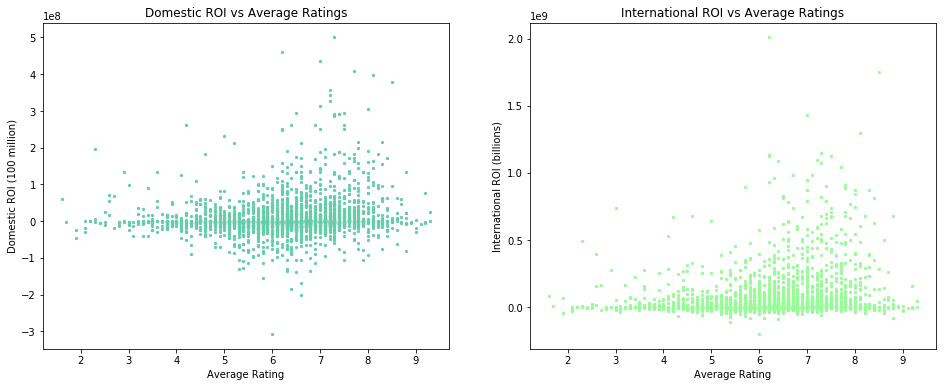

In [71]:
# Creating figure
fig = plt.figure(figsize=(16,6))

# setting axes 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot(221)

# create subplots
ax1.scatter(df_imbd_fin["averagerating"], df_imbd_fin["ROI_domestic"], color="mediumaquamarine", s=5)
ax2.scatter(df_imbd_fin["averagerating"], df_imbd_fin["ROI_international"], color="palegreen", s=5)
# ax3.plot(df_imbd_fin["averagerating"], z1, color="mediumaquamarine", s=5)


# Add descriptors
ax1.set_xlabel("Average Rating")
ax1.set_ylabel("Domestic ROI (100 million)")
ax1.set_title("Domestic ROI vs Average Ratings")

ax2.set_xlabel("Average Rating")
ax2.set_ylabel("International ROI (billions)")
ax2.set_title("International ROI vs Average Ratings")
print('ROI as a function of average rating');


There seems to be little correlation between Average Rating, but we can see that ROI tends to be highest between the range 6-8 for International ROI. It is important to note that while this range also sees the higher earnings for domestic sales, the same have the biggest losses. For further work we couldn investigate if there are any studios or actors that are in movies that consistently receive a rating from 6-8. 

Let’s now examine if there is any correlation between the production budget and ROI. 

ROI as a function production budget


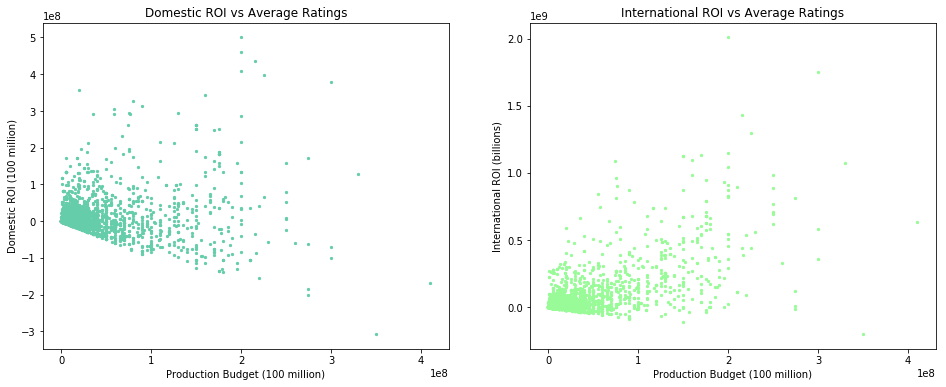

In [72]:
# Creating figure
fig = plt.figure(figsize=(16,6))

# setting axes
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# create subplots
ax1.scatter(df_imbd_fin["production_budget"], df_imbd_fin["ROI_domestic"], color="mediumaquamarine", s=5)
ax2.scatter(df_imbd_fin["production_budget"], df_imbd_fin["ROI_international"], color="palegreen", s=5)



# Add descriptors
ax1.set_xlabel("Production Budget (100 million)")
ax1.set_ylabel("Domestic ROI (100 million)")
ax1.set_title("Domestic ROI vs Average Ratings")

ax2.set_xlabel("Production Budget (100 million)")
ax2.set_ylabel("International ROI (billions)")
ax2.set_title("International ROI vs Average Ratings")
print('ROI as a function production budget');


It seems that for domestic ROI any production budget above 200 million, sees diminishing ROI, as well as the largest losses. Therefore, if the primary target is domestic, with a smaller international release - then it is best to stay within this budget. However, if the objective is to have a focus on the international market, then a production up to 300 million is potentially safe for a good return on investment. 
There are not enough data points for production budgets above 300 million, and the same will not be taken into account. 

Now let’s see if any correlation between production budget and average ratings exist. 


Text(0.5,1,'Average Ratings vs Production Budget')

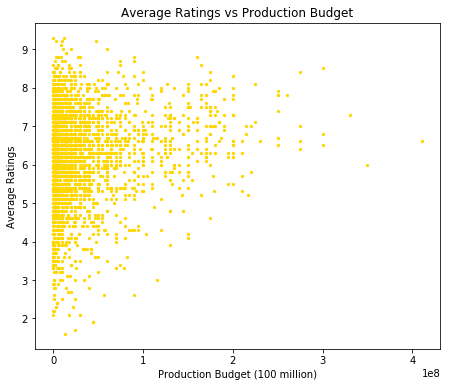

In [73]:
# Creating figure
fig = plt.figure(figsize=(16,6))

# setting axes
ax1 = fig.add_subplot(121)

# create subplots
ax1.scatter(df_imbd_fin["production_budget"], df_imbd_fin["averagerating"], color="gold", s=5)


# Add descriptors
ax1.set_xlabel("Production Budget (100 million)")
ax1.set_ylabel("Average Ratings")
ax1.set_title("Average Ratings vs Production Budget")




Here we can see that between the ranges of 100-200 million, ratings between 5 and 8 are the most prevalent, which somewhat agrees with our observations between average ratings and ROI. Given this data we can see that a possible objective is to shoot for around 200 in production budget to get average ratings between 6-8 and achieve higher ROIs. 

Let’s continue digging into differences between genres, to have a deeper sense of a holistic objective. 


<a id="Grr"></a>
## Genres, ROI and ratings
### Are there genres that have ratings within our specified range? If so what are their associated ROIs?

First let’s see if any genres have average ratings within our desired range (6-8). Then we will look deeper into these genres and see which one has the highest median for ROI, and then see if there is any correlation between production budget and ROI across these genres.

In [74]:
df_imbd_genre_rating_grouped = df_imbd_title_and_ratings_expanded.groupby(['genres'])['averagerating'].mean().reset_index().copy()


In [75]:
df_imbd_genre_rating_grouped.head(2)

genres  averagerating
0  Action       5.810361
1   Adult       3.766667

Text(0.5,1,'Average Ratings across Genres')

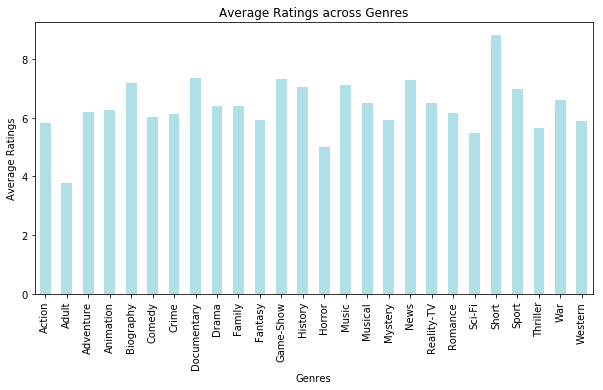

In [76]:
# Plotting genres vs averagerating
# fig = plt.figure(figsize=(20,20))
ax = df_imbd_genre_rating_grouped.plot.bar(x='genres', y='averagerating', rot=90, color="powderblue"
                                            , legend=False, figsize=(10,5))


# Add descriptors
ax.set_xlabel("Genres")
ax.set_ylabel("Average Ratings")
ax.set_title("Average Ratings across Genres")



Text(0.5,1,'Movie count across Genres')

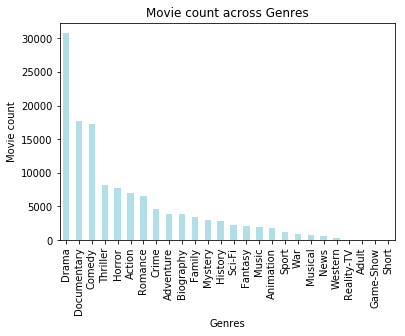

In [77]:
ax = df_imbd_title_and_ratings_expanded.genres.value_counts().plot(kind="bar"
                                                                                ,color="powderblue")
# df_imbd_genre_rating_grouped.plot.bar(x='genres', y='averagerating', rot=90, color="powderblue"
#                                             , legend=False, figsize=(10,5))


# Add descriptors
ax.set_xlabel("Genres")
ax.set_ylabel("Movie count")
ax.set_title("Movie count across Genres")


In [78]:
df_imbd_title_and_ratings_expanded.genres.value_counts()

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Action          6988
Romance         6589
Crime           4611
Adventure       3817
Biography       3809
Family          3412
Mystery         3039
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1968
Animation       1743
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genres, dtype: int64

In the above chart we can see that the following genres had their average rating within our range of interest:
- Biography
- Documentary
- Game Show
- History
- Music
- Musical 
- News
- Reality-TV
- Sport
- War <br><br>

From these we will need to eliminate those which are clearly TV shows and not movies, as well as filter the dataframe based on runtime. Also, given the value counts for our genres, we will remove any genre that has a count less than 500, as they will be underrepresented in the data, and whatever insights we get from these will be not very precise nor useful.

Using data from the Stephen Films institute for Film Data and Education below, we can see that since we will be studying documentaries, we should filter our data for runtimes at or above 86 min. We will assume then that this will leave only movies in the dataframe. 

ASSUMPTION: Filtering for movies with runtime above 85 min will eliminate most if not all TV shows from the dataset and thus won’t skew our analysis. 


<img src="Distribution_of_runtime_min.png">

<img src=Average_runtime_genres.png>

In [79]:
df_imbd_title_and_ratings_expanded.head(2)

tconst  averagerating  numvotes     primary_title    original_title  \
0  tt10356526            8.3        31  Laiye Je Yaarian  Laiye Je Yaarian   
1  tt10384606            8.9       559        Borderless        Borderless   

   start_year  runtime_minutes       genres  
0      2019.0            117.0      Romance  
1      2019.0             87.0  Documentary

In [80]:
df_imbd_title_and_ratings_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129294 entries, 0 to 73855
Data columns (total 8 columns):
tconst             129294 non-null object
averagerating      129294 non-null float64
numvotes           129294 non-null int64
primary_title      128490 non-null object
original_title     128490 non-null object
start_year         128490 non-null float64
runtime_minutes    118437 non-null float64
genres             128490 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


In [81]:
df_imbd_title_and_ratings_movies = df_imbd_title_and_ratings_expanded[df_imbd_title_and_ratings_expanded.runtime_minutes >= 85].copy()


In [82]:
genres_to_del = ["Reality-TV", 'Game-Show', 'News', 'Western', 'Adult', 'Short']
df_imbd_title_and_ratings_movies = df_imbd_title_and_ratings_movies[~df_imbd_title_and_ratings_movies['genres'].isin(genres_to_del)]


In [83]:
df_imbd_title_and_ratings_movies.genres.value_counts()

Drama          22178
Comedy         12206
Documentary     7372
Thriller        5761
Action          5190
Romance         5094
Horror          4226
Crime           3511
Adventure       2589
Biography       2240
Family          2204
Mystery         2153
History         1671
Fantasy         1442
Sci-Fi          1421
Music           1241
Animation        881
Sport            755
War              581
Musical          488
Name: genres, dtype: int64

Now that the data is further tailored to our needs, let’s recreate the bar chart above and re-evaluate which genres to further inspect.

In [84]:
df_imbd_title_and_ratings_movies = df_imbd_title_and_ratings_movies.groupby(['genres'])['averagerating'].mean().reset_index()


Text(0.5,1,'Average Ratings across Genres')

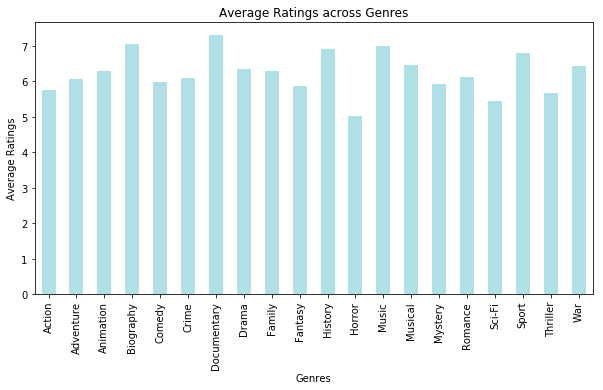

In [85]:
# Plotting genres vs averagerating
# fig = plt.figure(figsize=(20,20))
ax = df_imbd_title_and_ratings_movies.plot.bar(x='genres', y='averagerating', rot=90, color="powderblue"
                                            , legend=False, figsize=(10,5))

# Add descriptors
ax.set_xlabel("Genres")
ax.set_ylabel("Average Ratings")
ax.set_title("Average Ratings across Genres")


In [86]:
df_imbd_title_and_ratings_movies.sort_values("averagerating", ascending=False).head(15)

genres  averagerating
6   Documentary       7.306158
3     Biography       7.065670
12        Music       6.990653
10      History       6.903710
17        Sport       6.797351
13      Musical       6.461270
19          War       6.435628
7         Drama       6.365101
2     Animation       6.302611
8        Family       6.299637
15      Romance       6.119611
5         Crime       6.101623
1     Adventure       6.056315
4        Comedy       5.978191
14      Mystery       5.917975

Here we can see which movies we can continue examining. First, we will now look at genre and median ROI’s between these genres. Then we will select the top three genres based on median ROI and visalize the relationship between genre, production budget and ROI for these. This will help in determining which genres to potentially target. 

**OUT OF SCOPE:** We are not examining relationships between genres as movies can contain more then one genre. 

In [87]:
genres_to_keep = ['Documentary', 'Biography', 'Music', 'History', 'Sport', 'Musical', 'War', 'Drama', 'Animation', 'Family', 'Romance', 'Crime', 'Adventure']
df_imbd_fin_expanded = df_imbd_fin_expanded[df_imbd_fin_expanded["genres"].isin(genres_to_keep)]
df_imbd_fin_expanded["domestic_ROI"] = df_imbd_fin_expanded["domestic_gross"] - df_imbd_fin_expanded["production_budget"]
df_imbd_fin_expanded["international_ROI"] = df_imbd_fin_expanded["worldwide_gross"] - df_imbd_fin_expanded["production_budget"]


In [88]:
df_imbd_median = df_imbd_fin_expanded.groupby("genres").median()
df_imbd_median.sort_values("international_ROI", ascending=False)


production_budget  domestic_gross  worldwide_gross   day  month  \
genres                                                                         
Animation           78000000.0      85886987.0      249517956.0  17.0    7.0   
Adventure           79500000.0      63473323.0      176301374.5  17.0    7.0   
Family              25000000.0      42024533.0       60376247.0  18.0    8.0   
Biography           20000000.0      15436808.0       26097497.0  17.0    9.0   
Romance             13000000.0      11431425.0       19134335.5  17.0    7.0   
Music               11500000.0      12477202.0       17092887.5  17.0    8.0   
Sport               15500000.0      14025606.0       21232735.5  19.0    9.0   
Crime               20000000.0      14595363.5       26632927.5  16.0    8.0   
Drama               13000000.0       9737892.0       19054534.0  16.0    8.0   
History             22000000.0      10205616.0       24403192.0  15.0    8.0   
Documentary          9000000.0       6634587.5        9440671.0  16.0    7.0   
Musical              9650000.0       2471389.5       19773304.0  16.5    7.0   
War                 15000000.0       3855767.0       10005785.5  18.0    8.0   

               year  averagerating  runtime_minutes  domestic_ROI  \
genres                                                              
Animation    2014.0           6.60             93.0     1538435.0   
Adventure    2014.0           6.40            105.0    -2050000.0   
Family       2012.0           6.30            103.0     -151413.0   
Biography    2015.0           7.10            115.0    -1868590.0   
Romance      2012.0           6.30            104.0     -511499.0   
Music        2014.0           6.40            106.0      592624.0   
Sport        2013.5           6.80            111.0     -178667.5   
Crime        2013.0           6.40            106.0    -2668936.5   
Drama        2013.0           6.50            106.0    -1156229.0   
History      2015.0           6.90            119.0    -2921052.0   
Documentary  2011.0           7.20             81.0     -356721.0   
Musical      2011.0           6.50             99.0    -1109088.0   
War          2013.5           6.65            110.0    -4875434.0   

             international_ROI  
genres                          
Animation          146271037.0  
Adventure           87045238.5  
Family              29174545.0  
Biography            9382693.0  
Romance              7004176.0  
Music                6610357.0  
Sport                4852084.0  
Crime                4156853.5  
Drama                3500366.0  
History              3400715.0  
Documentary          1676158.0  
Musical                83762.0  
War                    -5321.0

Recently it seems that Animation, Adventure and Family movies have led to the highest international ROI’s as well as decent domestic ROI’s when compared to their peers. As such we will examine the relationship between production budget and ROI for these to get a general sense of the necessary production budget to achieve a high ROI. 

In [89]:
df_animation = df_imbd_fin_expanded.loc[df_imbd_fin_expanded["genres"] == "Animation"].copy()
df_adventure = df_imbd_fin_expanded.loc[df_imbd_fin_expanded["genres"] == "Adventure"].copy()
df_family = df_imbd_fin_expanded.loc[df_imbd_fin_expanded["genres"] == "Family"].copy()


In [90]:
df_adventure.head(2)

release_date                                        movie  \
1   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   2019-06-07                                 Dark Phoenix   

   production_budget  domestic_gross  worldwide_gross  day  month  year  \
1        410600000.0     241063875.0     1.045664e+09   20      5  2011   
2        350000000.0      42762350.0     1.497624e+08    7      6  2019   

   averagerating  runtime_minutes     genres  domestic_ROI  international_ROI  
1            6.6            136.0  Adventure  -169536125.0        635063875.0  
2            6.0            113.0  Adventure  -307237650.0       -200237650.0

ROI as a function production budget


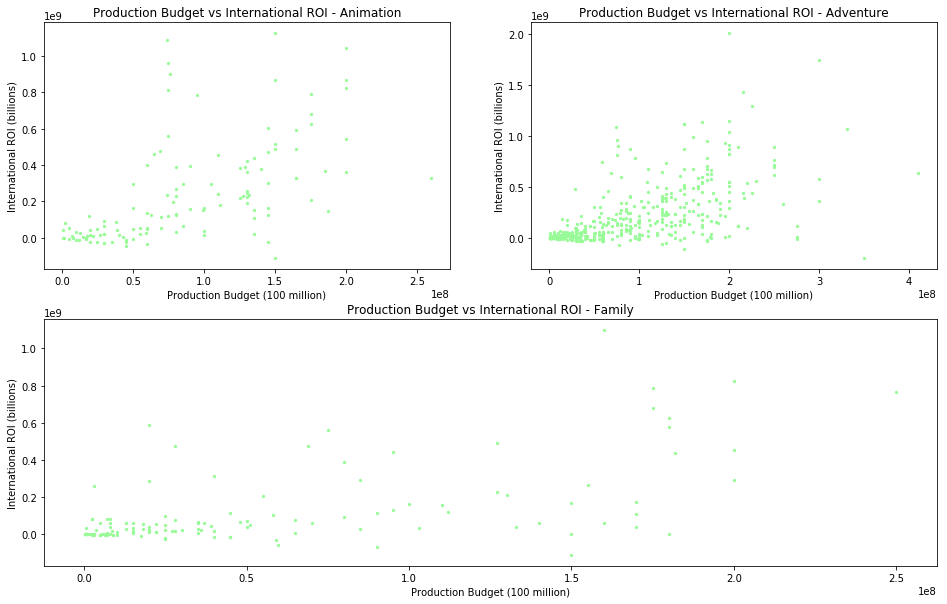

In [91]:
# Creating figure
fig = plt.figure(figsize=(16,10))

# setting axes
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)


# create subplots
ax1.scatter(df_animation["production_budget"], df_animation["international_ROI"], color="palegreen", s=5)
ax2.scatter(df_adventure["production_budget"], df_adventure["international_ROI"], color="palegreen", s=5)
ax3.scatter(df_family["production_budget"], df_family["international_ROI"], color="palegreen", s=5)


# Add descriptors
ax1.set_xlabel("Production Budget (100 million)")
ax1.set_ylabel("International ROI (billions)")
ax1.set_title("Production Budget vs International ROI - Animation")

ax2.set_xlabel("Production Budget (100 million)")
ax2.set_ylabel("International ROI (billions)")
ax2.set_title("Production Budget vs International ROI - Adventure")

ax3.set_xlabel("Production Budget (100 million)")
ax3.set_ylabel("International ROI (billions)")
ax3.set_title("Production Budget vs International ROI - Family")
print('ROI as a function production budget');



We can see that the distributions are fairly similar with 200 to 800 million being our target range for international ROI. Given the data thus far, a production budget of 150-300 million on an Animation, Adventure or Family (or a combination of the same) should yield a respectable ROI in the international market. We would also recommend focusing on an international release as domestic markets seem more volatile in terms of ROI.

<a id="Rpb"></a>

## Runtime and production budget
### What is the best range for runtime relative to production budget?<br>

Now that we know the approximate production budget, let’s observe a possible range for runtime minutes to adhere to. We are looking to see a mid production budget range and associated runtimes - if any. 

Trends on runtime minutes given production budget


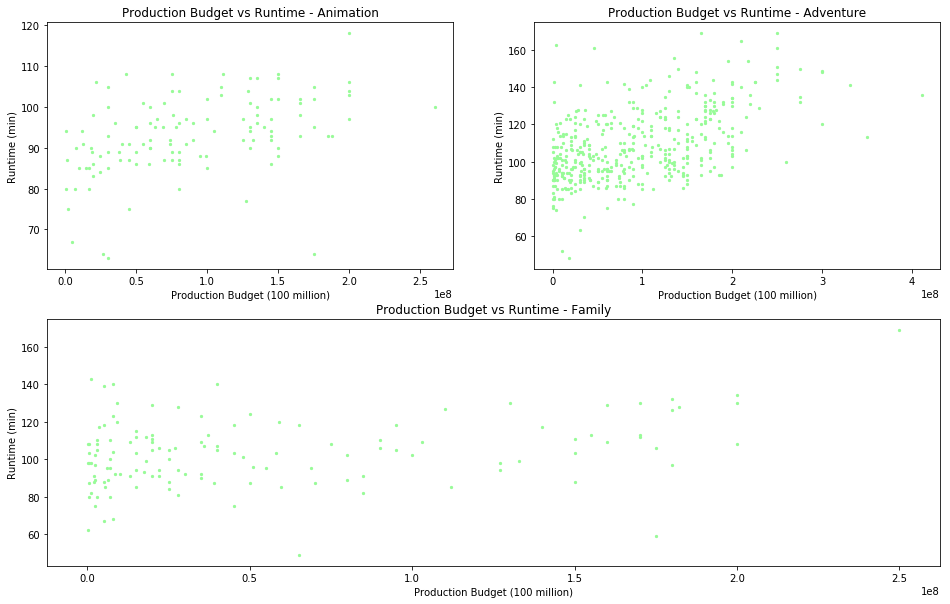

In [92]:
# Creating figure
fig = plt.figure(figsize=(16,10))

# setting axes
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)


# create subplots
ax1.scatter(df_animation["production_budget"], df_animation["runtime_minutes"], color="palegreen", s=5)
ax2.scatter(df_adventure["production_budget"], df_adventure["runtime_minutes"], color="palegreen", s=5)
ax3.scatter(df_family["production_budget"], df_family["runtime_minutes"], color="palegreen", s=5)


# Add descriptors
ax1.set_xlabel("Production Budget (100 million)")
ax1.set_ylabel("Runtime (min)")
ax1.set_title("Production Budget vs Runtime - Animation")

ax2.set_xlabel("Production Budget (100 million)")
ax2.set_ylabel("Runtime (min)")
ax2.set_title("Production Budget vs Runtime - Adventure")

ax3.set_xlabel("Production Budget (100 million)")
ax3.set_ylabel("Runtime (min)")
ax3.set_title("Production Budget vs Runtime - Family")
print('Trends on runtime minutes given production budget');


These charts show that runtime has little association with production budget for the Family genre, but there is a slight trend that when production budget increases so does length. For the Animation genre this trend is increased, and for the Adventure genre the trend is noticeable. This means that as runtime increases we would expect associated costs to increase, which is expected. For runtime related decision we would recommend a mix of the three genres, and to stick to a runtime not much longer than 120 min, as this is the upper bound for the animation genre. 

Let’s further examine the expected length for the feature film. 

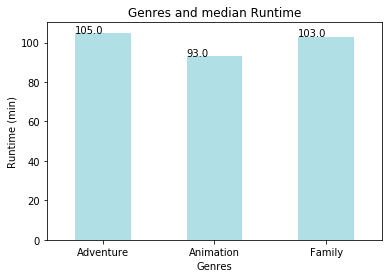

In [93]:
genres_selected = ['Animation', 'Adventure', 'Family']
df_selected_genres = df_imbd_fin_expanded.loc[df_imbd_fin_expanded["genres"].isin(genres_selected)].copy()
df_selected_genres = df_selected_genres[['genres','runtime_minutes']]

ax = df_selected_genres.groupby("genres").median().plot(kind="bar", color="powderblue", legend=False, rot=0)

ax.set_xlabel("Genres")
ax.set_ylabel("Runtime (min)")
ax.set_title("Genres and median Runtime")

# for i, label in enumerate(list(df_selected_genres.index)):
#     genres = df_selected_genres.ix[label]['genres']
#     ax.annotate(genres, (str(i), genres + 0.2))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))


Let’s quickly recap and modify our observations. A realistic target for ROI is around the range of 200 to 800 million for international ROI, if the production budget is close to or within the 150-300 million dollar range. We are basing these ranges solely on movies that are an Animation, Adventure or Family (or a combination of the same) film. We then recommend to stick to a runtime of no more than 120 min, and within the approximate range of 86 to 114 min. This range was re-calculated from the previous by finding the mean of the medians. The same equals 100 with a standard deviation of +- 14 for a 99.99% confidence level. Now let’s do a quick exploratory analysis for the expected competition moving forward.

<a id = "Ec"></a>
## Expected competition
### Is there a change in the number of released movies, production budgets and ROIs from 2015-2019 compared to five years prior?

Let’s look at the number of movies that have come out from 2015-2019 vs 2010-2014. 


In [186]:
df_release_dates = df_imbd_fin_expanded.loc[df_imbd_fin_expanded["genres"].isin(genres_selected)].copy()
df_release_dates = df_release_dates[["month", "year", "production_budget", "international_ROI"]]
df_release_dates.head(2)

month  year  production_budget  international_ROI
1      5  2011        410600000.0        635063875.0
2      6  2019        350000000.0       -200237650.0

In [187]:
df_release_dates["year"] = df_release_dates.year.astype("float64")
df_release_dates = df_release_dates.loc[df_release_dates["year"]>=2010]
df_release_dates["year"] = df_release_dates.year.astype("int64")
df_release_dates_year = df_release_dates[["year","international_ROI"]]

/Users/eduardo_calzadilla/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Trends across past decade


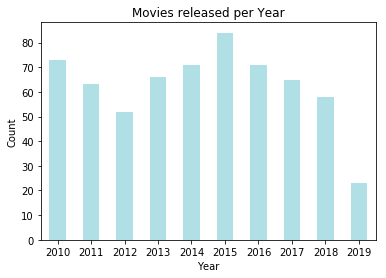

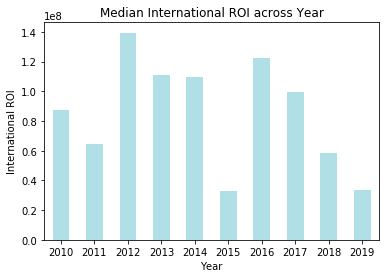

In [188]:
# setting axes
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1 = df_release_dates_year.groupby("year").size().plot(kind="bar", color="powderblue", rot=0)
ax2 = df_release_dates_year.groupby("year").median().plot(kind="bar", color="powderblue", legend=False, rot=0)

# setting axes labels
ax1.set_xlabel("Year")
ax1.set_ylabel("Count")
ax1.set_title("Movies released per Year")

ax2.set_xlabel("Year")
ax2.set_ylabel("International ROI")
ax2.set_title("Median International ROI across Year")

print('Trends across past decade');


We can see that the median International ROI as well as movies released has been trending downwards in the past 5 years (with the exception of ROI for 2015). This is an important observation as it could guide our expectations particularly when related to production budget. Now let’s compare production budget across years and then look at the median ROI binned. 

In [190]:
df_release_dates_production = df_release_dates[["year","production_budget"]]

Trends across past decade


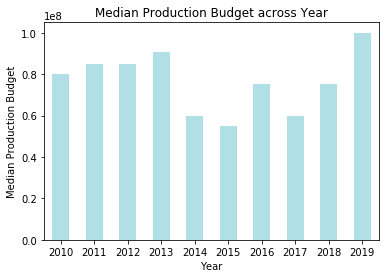

In [199]:
ax = df_release_dates_production.groupby("year").median().plot(kind="bar", color="powderblue", legend=False, rot=0)

ax.set_xlabel("Year")
ax.set_ylabel("Median Production Budget")
ax.set_title("Median Production Budget across Year")

print('Trends across past decade');

In [211]:
#create bins for pre-sepcified groupbins = np.linspace(df_release_dates_year.year.min(), df_release_dates_year.year.max(), 2)
groups = df_release_dates_year.groupby(np.digitize(df_release_dates_year.year, bins))

groups.mean()

year  international_ROI
1  2014.003317       2.076077e+08
2  2019.000000       1.406611e+08

In [208]:
bins = np.linspace(df_release_dates_production.year.min(), df_release_dates_production.year.max(), 2)
groups = df_release_dates_production.groupby(np.digitize(df_release_dates_production.year, bins))


groups.mean()

year  production_budget
1  2014.003317       8.759631e+07
2  2019.000000       1.163043e+08

Here we can see that the number of movies released has been trending downwards and that while the production budget is increasing, ROIs are decreasing. Therefore, it is important to keep production budgets close to our range, as ROIs have become more volatile. This could be due to many reasons, but a major confounding variable is the popularity of streaming services and their effect on movie release success. 